# CNN Training

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

2024-09-08 16:41:07.875974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 16:41:07.968089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 16:41:07.994686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 16:41:08.184539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Checking if GPU is available

In [2]:
tf.config.experimental.list_physical_devices("GPU")

I0000 00:00:1725806472.803835    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725806472.874575    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725806472.874622    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [3]:
DATA_DIR = os.path.join("data")

DATA_WITH_OUTLIERS_PATH = os.path.join(
    DATA_DIR, "balance_sheets_quarterly_processed.csv"
)
DATA_WITHOUT_OUTLIERS_PATH = os.path.join(
    DATA_DIR, "balance_sheets_quarterly_no_outliers.csv"
)

MODEL_WITH_OUTLIERS_NAME = "model_with_outliers"
MODEL_WITHOUT_OUTLIERS_NAME = "model_without_outliers"

## Creating and training a CNN model

### Use early stopping to stop training when results do not improve

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,  # Restores the weights from the epoch with the best validation loss
)

### Helper functions

In [5]:
def prepare_data(data_path):
    df = pd.read_csv(data_path)
    df = df.drop(columns=["symbol", "date"])

    X = df.drop(columns=["marketCap"])
    y = df["marketCap"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, X_test, y_train, y_test


def create_model(X_train):
    model = models.Sequential(
        [
            layers.Input(shape=(X_train.shape[1], 1)),
            layers.Conv1D(64, kernel_size=2, activation="relu"),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(128, kernel_size=2, activation="relu"),
            layers.Conv1D(256, kernel_size=2, activation="relu"),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mae"],
    )

    return model


def load_or_train_model(data_path, model_name):
    try:
        model = models.load_model(os.path.join("models", model_name + ".keras"))
        history = pd.read_csv(os.path.join("history", model_name + ".csv"))
        return model, history
    except (FileNotFoundError, ValueError):
        X_train, X_test, y_train, y_test = prepare_data(data_path)
        model = create_model(X_train)
        results = model.fit(
            X_train,
            y_train,
            epochs=200,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
        )

        models_dir = os.path.join("models")
        os.makedirs(models_dir, exist_ok=True)
        model.save(os.path.join(models_dir, model_name + ".keras"))

        history_dir = os.path.join("history")
        os.makedirs(history_dir, exist_ok=True)

        history_df = pd.DataFrame(results.history)
        history_df.to_csv(os.path.join(history_dir, model_name + ".csv"), index=False)

        return model, history_df

### Training the model

#### Model for data with outliers

In [6]:
with_outliers_model, with_outliers_history = load_or_train_model(
    DATA_WITH_OUTLIERS_PATH, MODEL_WITH_OUTLIERS_NAME
)

I0000 00:00:1725806473.072252    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725806473.072385    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725806473.072413    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725806473.365301    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725806473.365358    6189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-08

#### Model for data without outliers

In [7]:
without_outliers_model, without_outliers_history = load_or_train_model(
    DATA_WITHOUT_OUTLIERS_PATH, MODEL_WITHOUT_OUTLIERS_NAME
)

## Training results

### Helper functions

In [8]:
def evaluate_model(model, data_path):
    X_train, X_test, y_train, y_test = prepare_data(data_path)
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}, MAE: {mae}")

def plot_training_history(history):
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Loss History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history["mae"], label="Train MAE")
    plt.plot(history["val_mae"], label="Validation MAE")
    plt.title("MAE History")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Results

#### For model trained on data with outliers

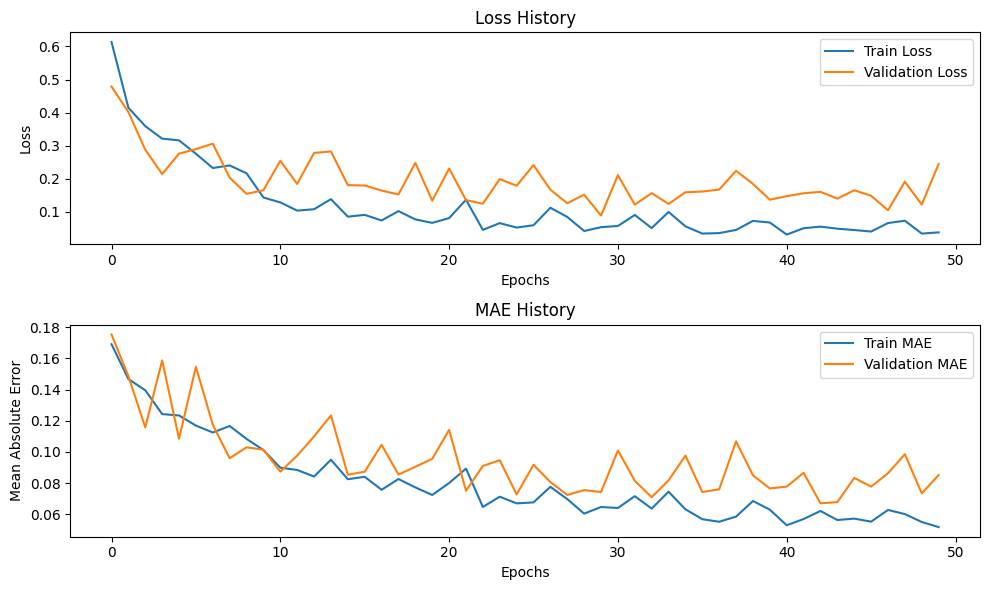

I0000 00:00:1725806476.121807    6288 service.cc:146] XLA service 0x7f0b40007bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725806476.121860    6288 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-08 16:41:16.144848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 16:41:16.215497: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 94/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8024 - mae: 0.1839  

I0000 00:00:1725806476.847799    6288 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8814 - mae: 0.1868
Loss: 1.5076346397399902, MAE: 0.2122168242931366


In [9]:
plot_training_history(with_outliers_history)
evaluate_model(with_outliers_model, DATA_WITH_OUTLIERS_PATH)

#### For model trained on data without outliers

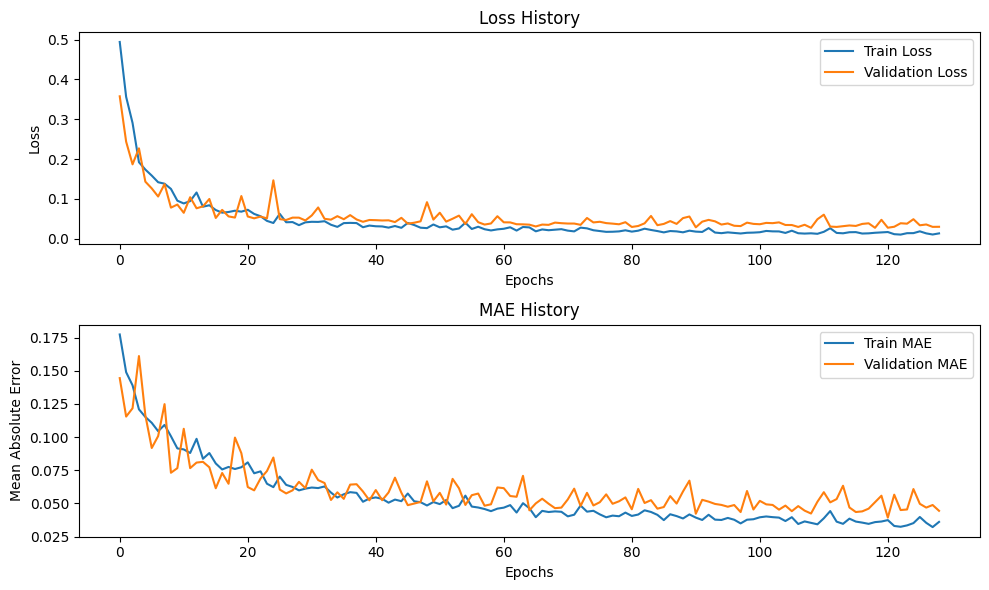

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7173 - mae: 0.1799
Loss: 0.7238311767578125, MAE: 0.17829982936382294


In [10]:
plot_training_history(without_outliers_history)
evaluate_model(without_outliers_model, DATA_WITHOUT_OUTLIERS_PATH)